# Transformadores e NLP

## Profs. André Carvalho e Altigran Soares

O que é ser fluente em uma linguagem?

Conhecer bem a gramática? 
Conhecer o significado de muitas palavras?

Um adulto fluente em inglês sabe o significado de entre 30 a 100 mil palavras (dependendo das definições utilizadas para o que significa conhecer uma palavra.

Isto significa que uma crinaça tem que aprender entre __7__ a __10__ palavras __POR DIA__ para alcançar este nível de vocabulário aos 20 anos.

Estudos empiricos mostram que no ensino fundamental e médio, é por aí mesmo.

Mas como?

__Lendo__.

Hipótese: Aprendemos sentidos das palavras através dos _contextos_ em que elas são encontradas.

Similar ao conceito de métodos como word2vec e afins.

__Pré-treino__: aprender representações de significados através do processamento de quantidades massivas de texto.

# Redes de auto-atenção: Transformadores

Transformers é um tipo de arquitetura de rede neural que processa sequências, como LSTMs.
 - Porém sem conexões recorrentes, que são ruins de paralelizar.
 
Transformadores mapeiam vetores de entrada $(x_1,x_2,...,x_n)$ para vetores de saída $(y_1,y_2,...,y_n)$ _do mesmo tamanho_.
 - Redes transformadoras são feitas de pilhas de blocos formado por camadas densas, lineares e camadas de __auto-atenção__.
 
Self-attention permite que a rede possa extrair informação de qualquer contexto, independente do tamanho ou distância, sem ter que passar por diversas conexões recorrentes, como nas RNNs.

# Camada de Atenção

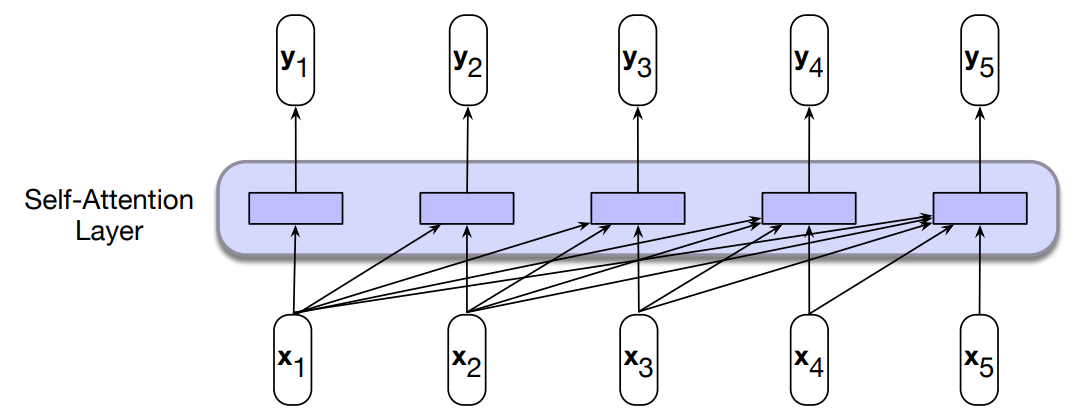


Essa é uma atenção causal simples, ou uma camada _backward-looking, self-attention_

# Uma camada de atenção simples

Para auxiliar o entendimento, vamos imaginar o cômputo de $y_3$.
 - Ele depende de comparações entre $x_3$ com os valores de $x_1$ e $x_2$.
 
A maneira mais simples de "comparar" vetores é com um produto escalar (dot), onde quanto mais similares os vetores maior o valor:

$$score(x_i,x_j) = x_i. x_j$$

O que pode dar valores até $\pm\infty$, então é normal normalizar. Se normalizar com softmax:

$$ \begin{aligned} \alpha_{i j} & =\operatorname{softmax}\left(\operatorname{score}\left(\mathbf{x}_i, \mathbf{x}_j\right)\right) \forall j \leq i \\ & =\frac{\exp \left(\operatorname{score}\left(\mathbf{x}_i, \mathbf{x}_j\right)\right)}{\sum_{k=1}^i \exp \left(\operatorname{score}\left(\mathbf{x}_i, \mathbf{x}_k\right)\right)} \forall j \leq i\end{aligned} $$

Dados os valores proporcionais, podemos ponderar os vetores de entrada:

$$\mathbf{y}_i=\sum_{j \leq i} \alpha_{i j} \mathbf{x}_j$$

# Papéis de entrada em Transformers

Uma ideia inovadora na implementação de transformadores, foi ver os elementos dos embeddings de entrada como tendo diferentes papéis de acordo com o contexto e atenção:

 - Consulta (Query) - O foco atual que está sendo comparado com todos os anteriores. O elemento da posição sendo considerada.
 - Chave (key) - Elementos _anteriores_ (nesse caso) que estão sendo comparados com o foco atual de atenção.
 - Valor (value) - O valor utilizado para computar a saída de um foco de atenção.
 
Assim, cada elemento da entrada pode assumir diferentes papéis para formar a saída final. Cada um desses papéis possui uma matriz de pesos própria $W^Q,W^K $ e $W^V$ que são utilizados para projetar uma entrada $x_i$ na sua representação em um papel específico:

$$ q_i = W^Qx_i; k_i = W^Kx_i; v_i = W^Vx_i;$$

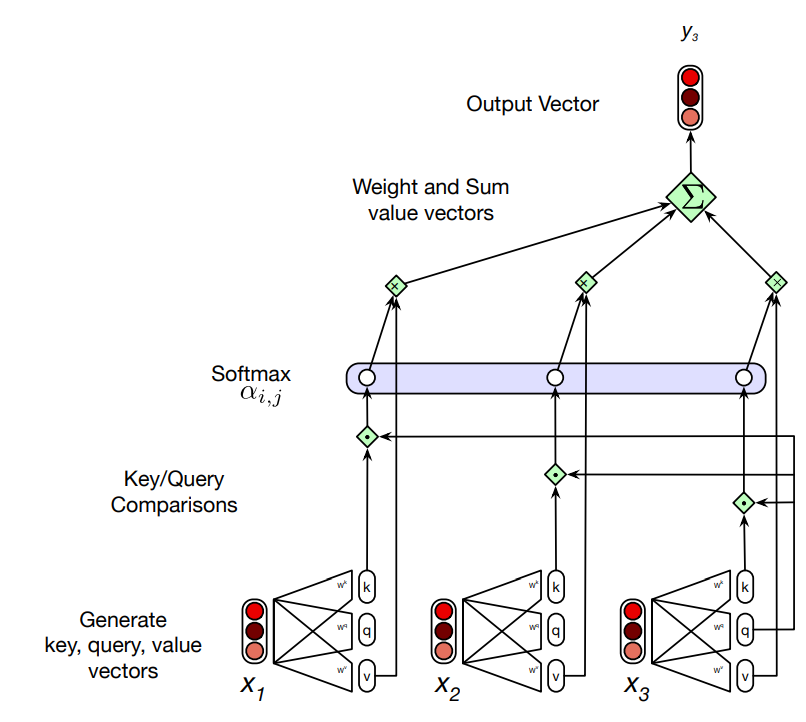

## Calculando

Produto escalar pode gerar valores muito grandes, o que pode levar a problemas numéricos e a problemas no gradiente durante o treino.
 - Tem que escalar!
 
Uma forma típica é dividir pelo raiz quadrado da dimensão dos vetores de atenção Q e K:

$$ score(x_i,x_j) = \frac{q_i.k_j}{\sqrt{d_k}} $$



## Calculando

Pode-se então calcular os vetores para toda a entrada:

$$ Q = XW^Q; K = XW^K; V = XW^V; $$

Podemos então calcular a atenção multiplicando Q e K^T, normalizando e então multiplicando por V, o que dá um vetor $N x d$, mesma dimensionalidade da entrada:

$$ SelfAttention(Q,K,V) = softmax\biggl(\frac{QK^T}{\sqrt{d_k}}\biggr)V $$

Aqui é um problema para language models, pois $QK^T$ está vendo tokens no futuro (após o _query_). Como resolver?

## Mascarando

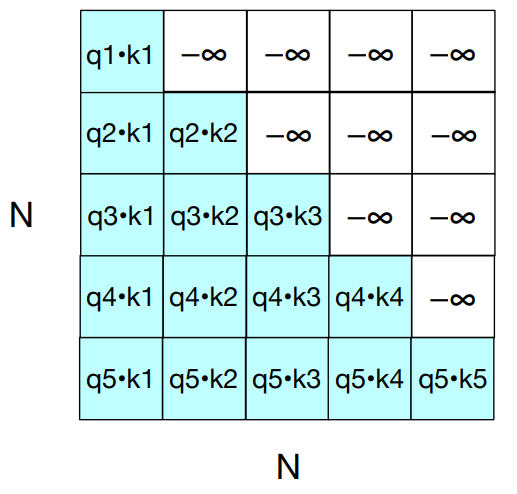

Aqui fica claro que uma camada de atenção tem tamanho  quadrático em relação à entrada, então é complicado ter entradas muito grandes pois o número de parâmetros explode.

Geralmente se usa paragrafos ou páginas como entrada.

# Blocos de transformadores

Uma das vantagens de se trabalhar com entrada e saída do mesmo tamanho é que você pode então utilizar pilhas de blocos iguais para gerar representações.

Um bloco de transformadores simples:

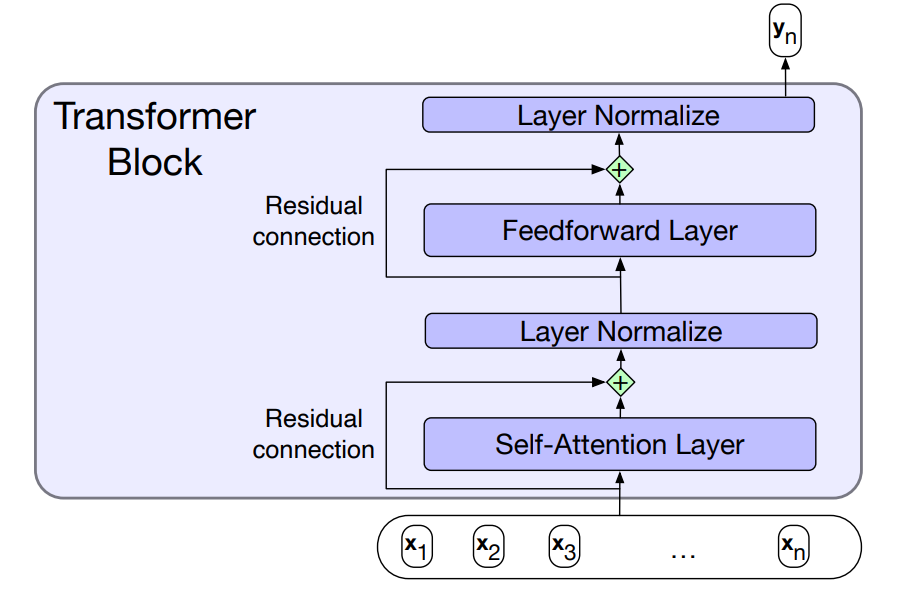

## Conexão residual

A conexão residual está aí para passar a informação das camadas inferiores para as superiores, garantindo que a informação original não se perca completamente durante o processamento.
 - Uma forma simples de usar residuais é somar com a saída de camadas de processamento:
 
Normalização de camada: standardization padrão:

$$ \hat{\mathbf{x}}=\frac{(\mathbf{x}-\mu)}{\sigma}$$

Com a adição de 2 parâmetros treináveis, representando piso e ganho na normalização:

$$ LayerNorm = \gamma \hat{\mathbf{x}} + \beta $$

# Atenção Multi-head

Palavras em uma sentença podem ter diversos relacionamentos entre si, ao mesmo tempo. 
 - Um sujeito pode ter um efeito em um verbo e outro distinto no objeto de uma frase.
 - Imaginem o efeito de um _não_ em termos de atenção.

Só um bloco transformador (Q,K,V) dificilmente capturaria todas estas relações entre entradas.

Para resolver: Múltiplas camadas paralelas de atenção, chamadas de cabeças (head).

# Atenção Multi-head

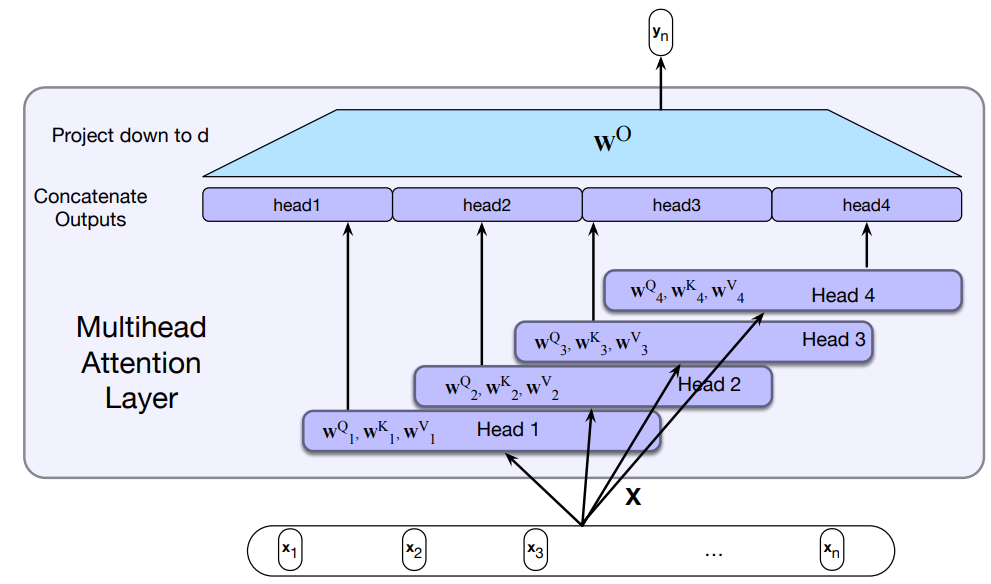

# Embeddings posicionais

Até agora, a posição dos tokens na entrada está tendo pouco efeito na sua representação, salvo por chaves de outras posições. 
 - Como adicionar essa informação nas representações?
 
Adicionando embeddings posicionais às entradas.

Uma solução é _treinar_ embeddings que representem cada posição.

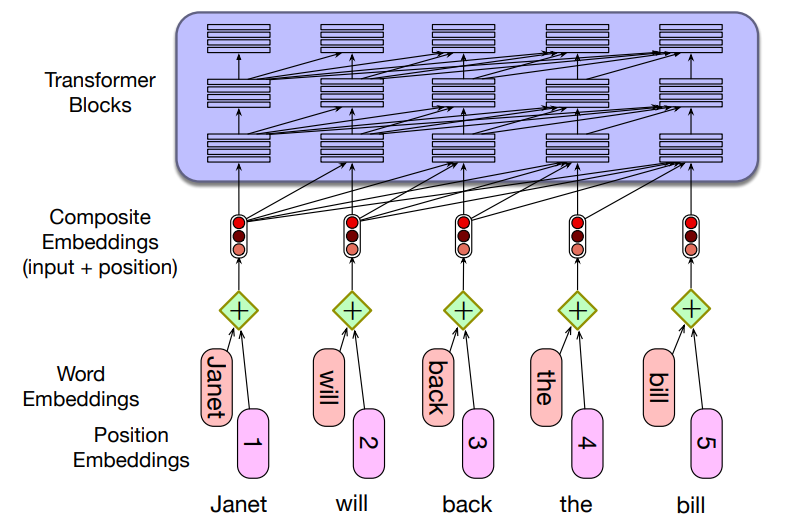

Problema: Muito treino para as posições iniciais, poucos para as finais (já que frases longas são bem mais raras).

Alternativa: Usar uma função fixa que capture os relacionamentos entre posições na frase, ou seja, que represente que a posição 4 tem mais a ver com a 5 que a 17.

O paper original dos transformers (Attention is all you need) usava uma combinação de seno-cosseno.

# Encoding posicional

PS: Tudo aqui é magia negra arbitrária ad hoc (mas que deixa a função bonitinha).

Dada uma posição $t$ na entrada, o embedding posicional dela será:

$${\overrightarrow{p_t}}^{(i)}=f(t)^{(i)}:= \begin{cases}\sin \left(\omega_k . t\right), & \text { if } i=2 k \\ \cos \left(\omega_k . t\right), & \text { if } i=2 k+1\end{cases}$$

Onde

$$\omega_k=\frac{1}{10000^{2 k / d}}$$

Para facilitar a visualização, o vetor posicional pode ser visto assim:

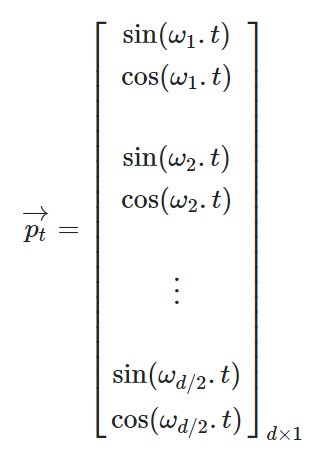

Visualizando (cada linha é uma posição):

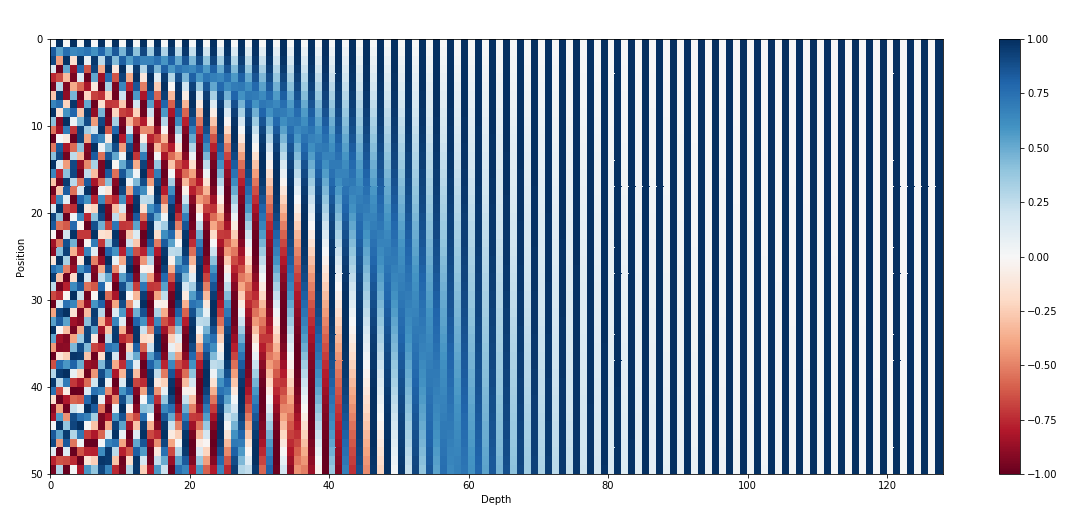

Mais detalhes: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

# Modelos de Linguagem com Transformadores

Modelos de linguagem com transformers são similares aos usando RNN (seq2seq).

Autoregreessor para prever a próxima palavra $y_t$ usando cross-entropy:

$$ L_{CE}(\hat{y_t},y_t)=-log\hat{y_t}[w_{t+1}] $$

Neste caso, treinamos com _professor_. Ao invés de usar a última saída prevista pelo modelo como próximo input, usamos a saída correta do treino, para diminuir impactos negativos de erros do decodificador.

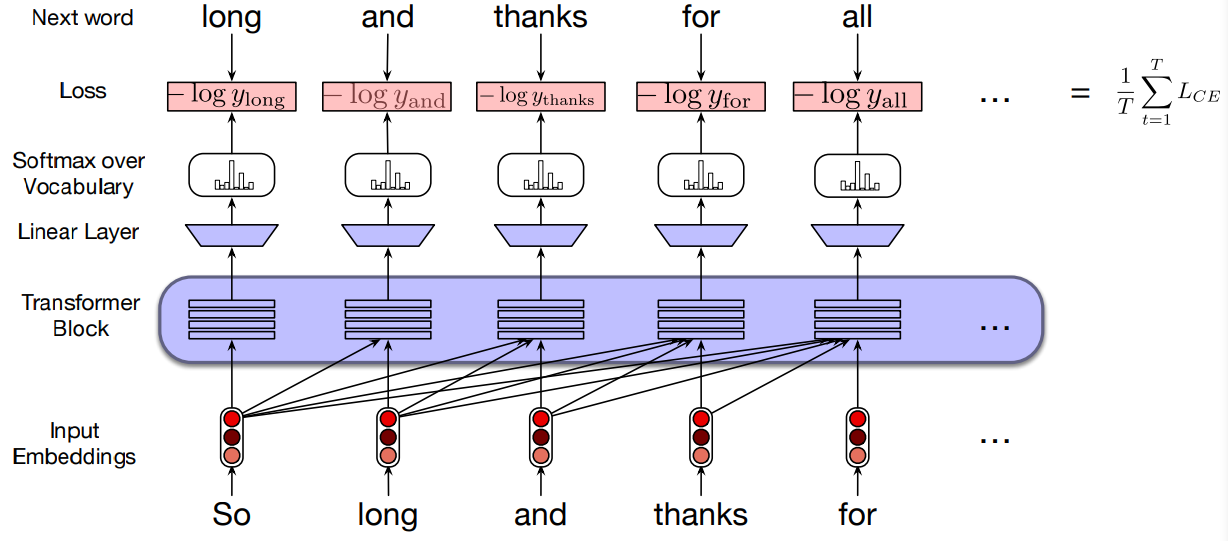

Diferente das RNNs, todas as saídas podem ser computadas em paralelo pois não há dependência na mesma camada.

# Gerando Texto

Podemos então usar nosso modelo como um LM gerador de texto autogressivo amostrando constantemente as próximas palavras.
 - Inicia com `<s>` e use esse embedding para gerar a primeira palavra.
 - Continue gerando até alcançar um `<\s>`.

Mas como gerar estas palavras?


> The Curious Case of Neural Text Degeneration - Holtzman et al 2020.

## Abordagem Gulosa

Para cada token, aplicar um softmax na saída e escolher a palavra com maior probabilidade:

$$ \hat{y_t} = argmax_{w \in V} P(w|y_1...y_{t-1}) $$

Esta abordagem é chamada de gulosa pois sempre é feita uma escolha que é __ótima local__, sem contudo verificar todas as possibilidades, o que pode levar a perda da frase com maior probabilidade global.

## Abordagens Amostrais

Outra saída é, já que temos uma distribuição ded probabilidades, simplesmente escolher o termo de acordo com a sua probabilidade.
 - Contudo, devido ao tamanho da cauda longa, tem uma chance real de trazer lixo.
 
_Top-k_ sampling:
 - Amostragem apenas nos top-k termos.

### Top-k Sampling

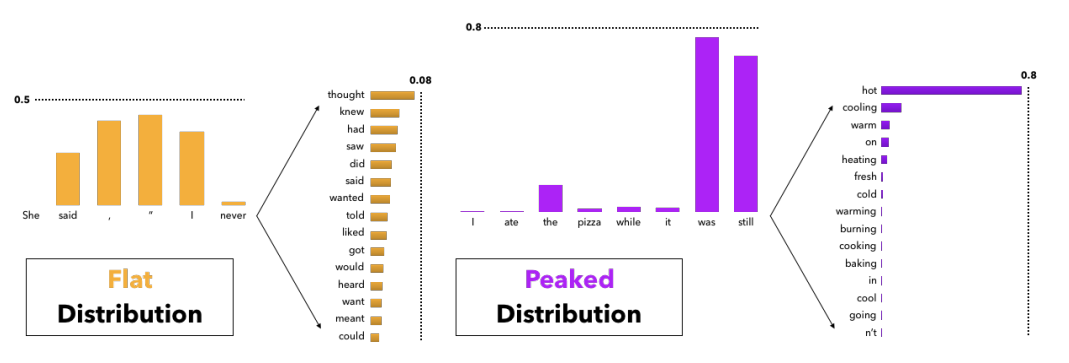

Quais seriam os problemas que essas distribuições trazem para a escolha de `k`?

## Amostragem com temperatura

Ao invés de usar softmax direto, se usa um parâmetro de temperatura `t` para "esfriar" a distribuição, aumentando a prevalência de poucos termos com probabilidade alta e achatando a cauda longa.

$$p\left(x=V_l \mid x_{1: i-1}\right)=\frac{\exp \left(u_l / t\right)}{\sum_{l^{\prime}} \exp \left(u_l^{\prime} / t\right)}$$

Contudo, estudos mostraram que apesar de melhorar a geração, isto vem com um custo de diminuição na diversidade de respostas.

## Nucleous Sampling

Ao invés de um _k_ fixo, se usa um valor mínimo de probabilidade no softmax para definir quais são os candidatos a serem amostrados:

$$\sum_{x \in V^{(p)}} P\left(x \mid x_{1: i-1}\right) \geq p$$

Com a distribuição sendo reescalada:

$$P^{\prime}\left(x \mid x_{1: i-1}\right)= \begin{cases}P\left(x \mid x_{1: i-1}\right) / p^{\prime} & \text { if } x \in V^{(p)} \\ 0 & \text { otherwise }\end{cases}$$

## Beam Search

Estamos partindo do pressuposto que um algoritmo guloso é ruim. Mas será que é mesmo?

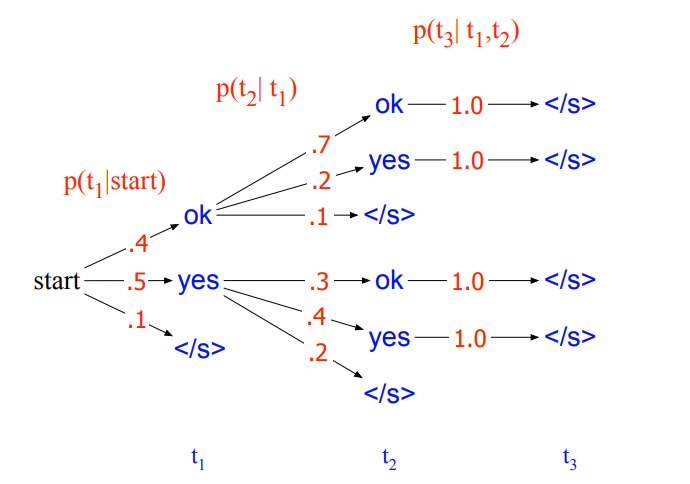

Testar todas as combinações de tokens com programação dinâmica (tipo um viterbi) não escala para problemas de dependência longa como textos assim.

Para garantir o resultado ótimo, deve-se testar __todas__ as possibilidades.

Obviamente, não dá.

Solução: Heurística.

## Beam Search

Ao invés de escolher o melhor token a cada posição, são guardados os _k_ melhores tokens.
 - Esse _k_ é a largura do raio de busca (beam width).
 
No primeiro token, se usa o softmax para escolher as _k_ melhores opções, que são chamadas de _hipóteses_.

Para cada uma dessas hipóteses, se usa o modelo para prever a próxima palavra, gerando $kV$ novas hipóteses.
 - Estas são de novo podadas para haverem apenas _k_ hipóteses.
 - E o processo é repetido.

### Beam search com k=2

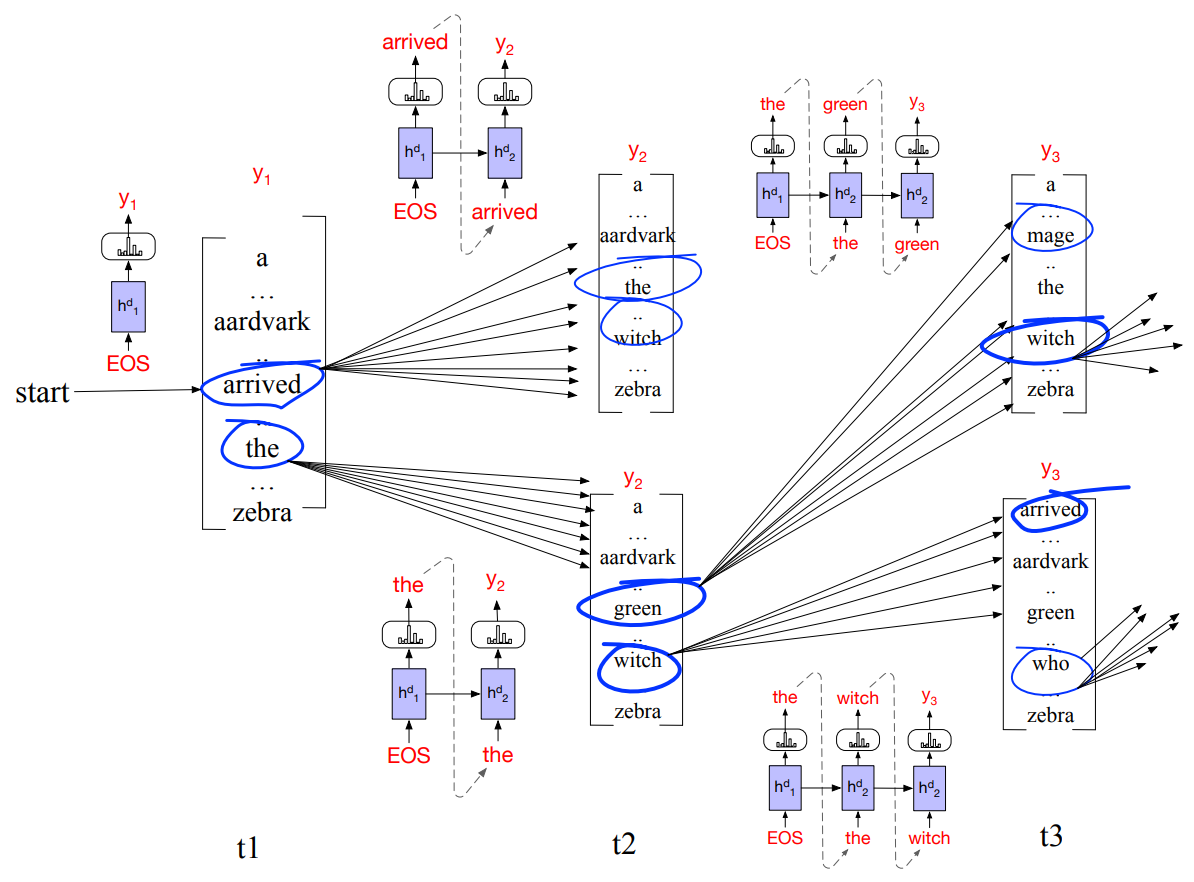

## Beam Search

O processo repete até encontrar `</s>` em todas as `k` hipóteses. Cada hipótese que acaba é removida das candidatas e o k é reduzido em um, e o processo continua até `k==0`

Mas como computa a probabilidade de uma hipótese? Calculando a probabilidade da sentença inteira computada até ali:

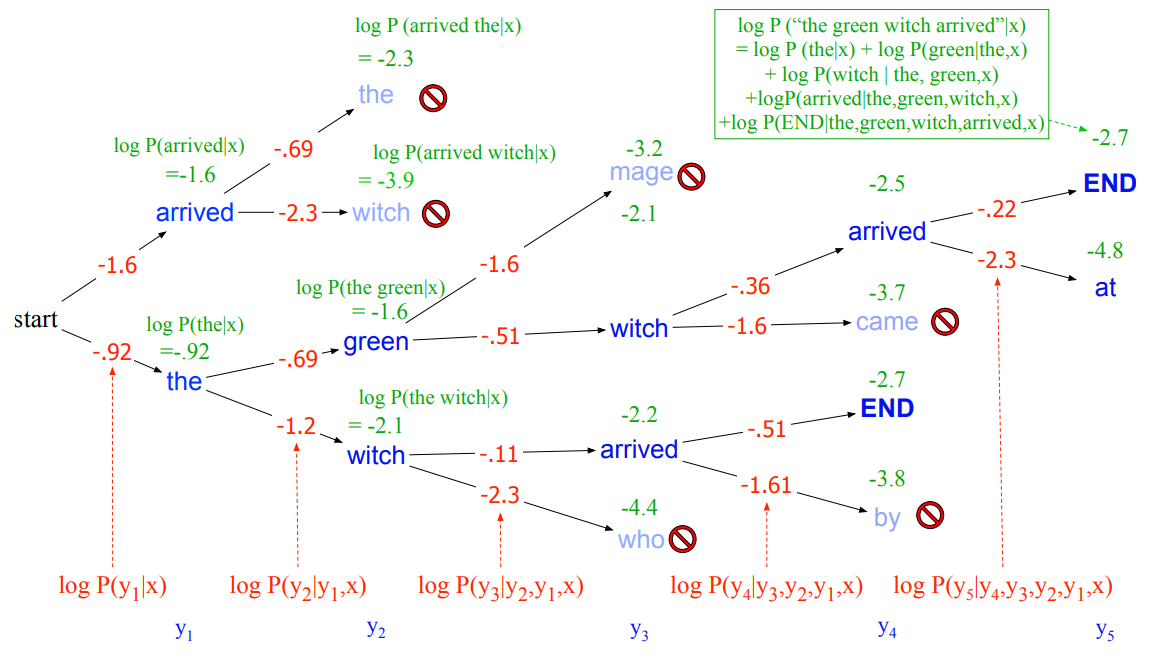